## Урок 6. Feature Engineering, Feature Selection, part II

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats.mstats import winsorize
import warnings
import xgboost as xgb
from typing import List, Optional

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, roc_auc_score
import time
from datetime import datetime, date
 
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount("/content/for_colab")
# !unzip "/content/for_colab/My Drive/for_colab/assignment2_data.zip" -d /content/data


Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.


In [3]:
train_data = pd.read_csv("data/assignment_2_train.csv")
test_data = pd.read_csv("data/assignment_2_test.csv")
train_data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test_data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,3059.949951,3059.949951,3059.949951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3059.949951,3059.949951,3059.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(train_data.shape, test_data.shape)

(180000, 394) (100001, 394)


In [6]:
le = LabelEncoder()
features_2 = ["card1", "card2", "card3", "card5", "addr1", "addr2"]
agr_card_addr_features = ["card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"]

def split_features(df):
    categorical_features = df.select_dtypes(include=[np.object]).columns
    numerical_features = list(set(df.columns) - set(categorical_features))
    return numerical_features, categorical_features

def create_stats_log(data: pd.DataFrame, 
                    feature: [str]) -> pd.DataFrame:
    
    stats = data.copy()
    stats["TransactionAmt_int"] = (stats["TransactionAmt"] // 1).astype(int)
    stats["TransactionAmt_frac"] = stats["TransactionAmt"] - stats["TransactionAmt_int"]
    stats["TransactionAmt_log"] = np.log(stats["TransactionAmt"])
    
    return stats

def create_stats(data: pd.DataFrame, 
                 groupby_col: List[str], 
                 stat: List[str],
                 feature: [str]) -> pd.DataFrame:
    
    stats = data[groupby_col]
    stats[feature] = data[feature]
    for gr_columns in groupby_col:
        data_grouped = data.groupby(gr_columns)
        for i in stat:
            columns = f"{feature}_{i}_{gr_columns}".upper()
            stats[columns] = data_grouped[feature].transform(i)
            columns_relationship = columns + "_relationship"
            stats[columns_relationship] = stats[feature] / stats[columns]

    stats = stats.drop(groupby_col, axis=1)
    stats = stats.drop(feature, axis=1)
    stats = stats.fillna(-9999)
    
    return stats

def data_from_lesson_5(train_df, test_df):
    data = pd.concat([train_df, test_df], axis=0)
    data = data.reset_index(drop=True)

    base_time_dt = time.mktime(date(2017, 12, 1).timetuple())
    # print(base_time_dt,"-", datetime.fromtimestamp(base_time_dt).strftime('%Y-%m-%d'))
    data["TransactionDT_date"] = pd.to_datetime(data.TransactionDT + base_time_dt, unit='s')
    data["TransactionDT_year"] = data["TransactionDT_date"].dt.year
    data["TransactionDT_month"] = data["TransactionDT_date"].dt.month
    data["TransactionDT_weekday"] = data["TransactionDT_date"].dt.weekday
    data["TransactionDT_hour"] = data["TransactionDT_date"].dt.hour
    data["TransactionDT_day"] = data["TransactionDT_date"].dt.day
    data = data.drop("TransactionDT_date", axis=1)

    data[features_2] = data[features_2].fillna(9)
    data["card_1_2"] = data["card1"].astype('str') + data["card2"].astype('str')
    data["card_1_2_3_5"] = data["card_1_2"] +  data["card3"].astype('str') + data["card5"].astype('str')
    data["card_1_2_3_5_addr_1_2"] = data["card_1_2_3_5"] + data["addr1"].astype('str') + data["addr2"].astype('str')

    data["card1freq_enc"]= data["card1"].map(data["card1"].value_counts(normalize=True))
    data["card2freq_enc"]= data["card2"].map(data["card2"].value_counts(normalize=True))
    data["card3freq_enc"]= data["card3"].map(data["card3"].value_counts(normalize=True))
    data["card5freq_enc"]= data["card5"].map(data["card5"].value_counts(normalize=True))
    data["addr1freq_enc"]= data["addr1"].map(data["addr1"].value_counts(normalize=True))
    data["addr2freq_enc"]= data["addr2"].map(data["addr2"].value_counts(normalize=True))

    data["card_1_2_freq_enc"]= data["card_1_2"].map(data["card_1_2"].value_counts(normalize=True))
    data["card_1_2_3_5_freq_enc"] = data["card_1_2_3_5"].map(data["card_1_2_3_5"].value_counts(normalize=True))
    data["card_1_2_3_5_addr_1_2_freq_enc"] = data["card_1_2_3_5_addr_1_2"].map(data["card_1_2_3_5_addr_1_2"].
                                                                                 value_counts(normalize=True))
    
    groupby_col = ["card1", "card2", "card3", "card5", "addr1", "addr2", "card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"] 
    stat = ["mean", "std"]
    stat_data_TAmt = create_stats(data, groupby_col=groupby_col, stat=stat, feature="TransactionAmt")
    stat_data_D15 = create_stats(data, groupby_col=groupby_col, stat=stat, feature="D15")
    stats_data_log = create_stats_log(data, "TransactionAmt")
    data[stat_data_TAmt.columns] = stat_data_TAmt
    data[stat_data_D15.columns] = stat_data_D15
    data[stats_data_log.columns] = stats_data_log

    categorical_features = split_features(data)[1]
    # print(categorical_features)
    for column in categorical_features:
        data[column] = data[column].replace(np.nan, 'none', regex=True)
        data[column] = le.fit_transform(data[column])

    # for column in data.columns:
    #     data[column] = data[column].fillna(-9999) 
    
    train_df, test_df = data[:180000], data[180000:]
    return train_df, test_df


In [7]:
train_df, test_df = data_from_lesson_5(train_data, test_data)
train_df.shape, test_df.shape

((180000, 486), (100001, 486))

In [8]:
train_df.head(n=20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2_relationship,D15_MEAN_CARD1,D15_MEAN_CARD1_relationship,D15_STD_CARD1,D15_STD_CARD1_relationship,D15_MEAN_CARD2,D15_MEAN_CARD2_relationship,D15_STD_CARD2,D15_STD_CARD2_relationship,D15_MEAN_CARD3,D15_MEAN_CARD3_relationship,D15_STD_CARD3,D15_STD_CARD3_relationship,D15_MEAN_CARD5,D15_MEAN_CARD5_relationship,D15_STD_CARD5,D15_STD_CARD5_relationship,D15_MEAN_ADDR1,D15_MEAN_ADDR1_relationship,D15_STD_ADDR1,D15_STD_ADDR1_relationship,D15_MEAN_ADDR2,D15_MEAN_ADDR2_relationship,D15_STD_ADDR2,D15_STD_ADDR2_relationship,D15_MEAN_CARD_1_2,D15_MEAN_CARD_1_2_relationship,D15_STD_CARD_1_2,D15_STD_CARD_1_2_relationship,D15_MEAN_CARD_1_2_3_5,D15_MEAN_CARD_1_2_3_5_relationship,D15_STD_CARD_1_2_3_5,D15_STD_CARD_1_2_3_5_relationship,D15_MEAN_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,D15_STD_CARD_1_2_3_5_ADDR_1_2,D15_STD_CARD_1_2_3_5_ADDR_1_2_relationship,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
0,2987000,0,86400,68.500,4,13926,9.0,150.0,1,142.0,1,315.0,87.0,19.0,NaN,34,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999.000000,3.866667,0.000000,10.147953,0.000000,137.341994,0.000000,181.506756,0.000000,169.071464,0.000000,194.454596,0.000000,106.934066,0.000000,169.410140,0.000000,192.287981,0.000000,204.842587,0.000000,170.162992,0.000000,194.610981,0.000000,0.500000,0.000000,0.577350,0.000000,0.500000,0.000000,0.577350,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,68,0.500,4.226834
1,2987001,0,86401,29.000,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.037691,127.908772,0.000000,184.973710,0.000000,138.362441,0.000000,185.462955,0.000000,169.071464,0.000000,194.454596,0.000000,115.791266,0.000000,178.492744,0.000000,191.837859,0.000000,201.730856,0.000000,170.162992,0.000000,194.610981,0.000000,128.666667,0.000000,185.657269,0.000000,128.666667,0.000000,185.657269,0.000000,86.612903,0.000000,117.658171,0.000000,29,0.000,3.367296
2,2987002,0,86469,59.000,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,NaN,36,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,4.234311,114.748284,2.745139,166.484470,1.892068,186.886432,1.685516,200.670841,1.569735,169.071464,1.863117,194.454596,1.619915,128.663077,2.448255,170.523998,1.847247,180.500353,1.745149,199.068411,1.582371,170.162992,1.851166,194.610981,1.618614,115.066820,2.737540,166.822990,1.888229,115.066820,2.737540,166.822990,1.888229,58.812500,5.356004,124.244500,2.535323,59,0.000,4.077537
3,2987003,0,86499,50.000,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,NaN,NaN,54,34,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.178052,188.179548,0.589862,200.587961,0.553373,177.997436,0.623604,197.497789,0.562032,169.071464,0.656527,194.454596,0.570827,181.120683,0.612851,199.225906,0.557156,152.921082,0.725865,184.037418,0.603138,170.162992,0.652316,194.610981,0.570369,187.835224,0.590943,200.388089,0.553925,187.835224,0.590943,200.388089,0.553925,167.724138,0.661801,141.582398,0.783996,50,0.000,3.912023
4,2987004,0,86506,50.000,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,NaN,NaN,16,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999.000000,4.750000,-9999.000000,6.184658,-9999.000000,162.303592,-9999.000000,198.166385,-9999.000000,169.071464,-9999.000000,194.454596,-9999.000000,115.791266,-9999.000000,178.492744,-9999.000000,171.067308,-9999.000000,191.358484,-9999.000000,170.162992,-9999.000000,194.610981,-9999.000000,4.750000,-9999.000000,6.184658,-9999.000000,4.750000,-9999.000000,6.18

In [9]:
split_features(train_df)[1]

Index([], dtype='object')

In [10]:
numerical_features = split_features(train_df)[0]

In [12]:
x_train, x_valid = train_test_split(
    train_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = (test_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = test_df["isFraud"]

In [13]:
numerical_features = split_features(x_train)[0]

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
# print(len(numerical_features))

x_train.shape = 108000 rows, 483 cols
x_valid.shape = 72000 rows, 483 cols
x_test.shape = 100001 rows, 483 cols


In [14]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [15]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [16]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.652059	test-auc:0.622476
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.753557	test-auc:0.705839
[20]	train-auc:0.831002	test-auc:0.785159
[30]	train-auc:0.866011	test-auc:0.839845
[40]	train-auc:0.879998	test-auc:0.850809
[50]	train-auc:0.891595	test-auc:0.857813
[60]	train-auc:0.897975	test-auc:0.861203
[70]	train-auc:0.904153	test-auc:0.862042
[80]	train-auc:0.909009	test-auc:0.863608
[90]	train-auc:0.912344	test-auc:0.864943
[100]	train-auc:0.915351	test-auc:0.86561
[110]	train-auc:0.917891	test-auc:0.865715
[120]	train-auc:0.91962	test-auc:0.866136
[130]	train-auc:0.921485	test-auc:0.8668
[140]	train-auc:0.923109	test-auc:0.8677
[150]	train-auc:0.924347	test-auc:0.868148
[160]	train-auc:0.925686	test-auc:0.867865
[170]	train-auc:0.926031	test-auc:0.867845
Stopping. Best iteration:
[149]	train-auc:0.924269	test-auc:0.868204



In [17]:
train_roc_auc_score_0 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_0 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_0 = roc_auc_score(y_test, model.predict(dtest))

In [18]:
print('train: %.4f' % train_roc_auc_score_0)
print('valid: %.4f' % valid_roc_auc_score_0)
print('test: %.4f' % test_roc_auc_score_0)

train: 0.9260
valid: 0.9059
test: 0.8678


Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.


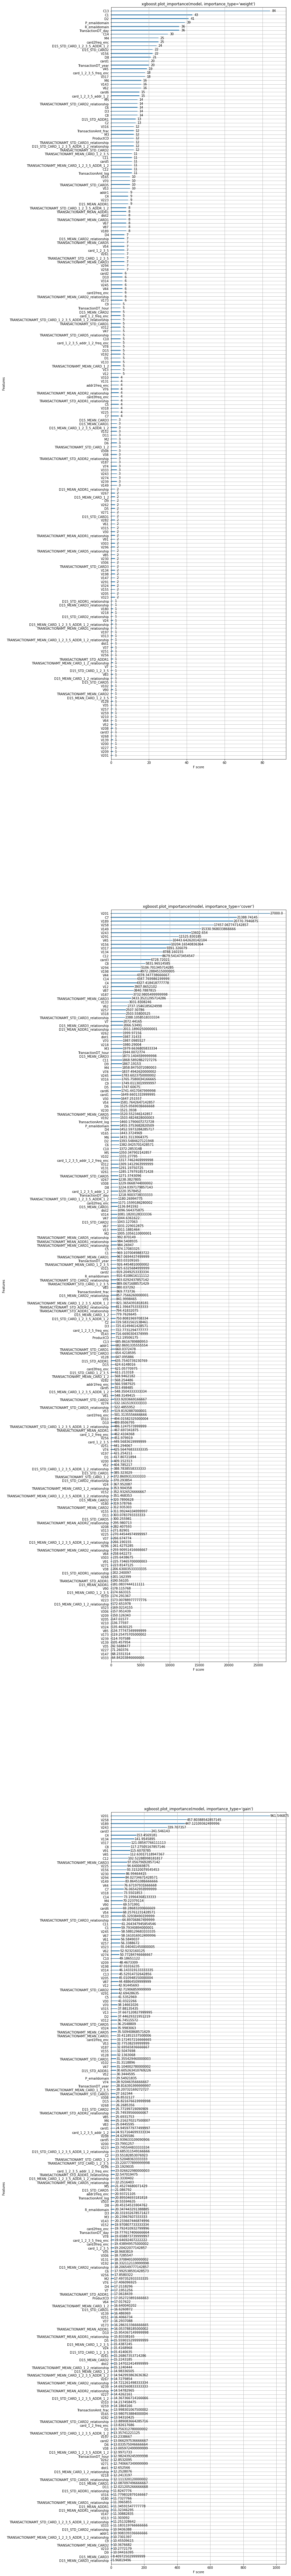

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(10, 150))

xgb.plot_importance(model, ax=ax[0])
ax[0].set_title("xgboost.plot_importance(model, importance_type='weight')")

xgb.plot_importance(model, ax=ax[1], importance_type="cover")
ax[1].set_title("xgboost.plot_importance(model, importance_type='cover')")

xgb.plot_importance(model, ax=ax[2], importance_type="gain")
ax[2].set_title("xgboost.plot_importance(model, importance_type='gain')")
plt.show()

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.


Задание 3: использовать permutation importance, выполнить задание 1 и 2.


Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.


Задание 5: использовать shap, выполнить задание 1 и 2.


Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.